# Traffic sign classification
Using the **German traffic sign** dataset, we are going to create with **tensorflow** and some tecnical things a Neural Network capable of identifying what is the image.

Dependencies:
- opencv
- tensorflow
- matplotlib

Dataset:
- [German Traffic Sign](https://benchmark.ini.rub.de/gtsrb_dataset.html)

More information:
- https://blog.roboflow.com/train-test-split/
- https://towardsdatascience.com/5-most-well-known-cnn-architectures-visualized-af76f1f0065e


In [1]:
!rm -rf sample_data

In [2]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip

--2023-05-04 09:45:11--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187490228 (179M) [application/zip]
Saving to: ‘GTSRB-Training_fixed.zip’

GTSRB-Training_fixe 100%[===================>] 178.80M  25.5MB/s    in 7.9s    

2023-05-04 09:45:20 (22.5 MB/s) - ‘GTSRB-Training_fixed.zip’ saved [187490228/187490228]



In [3]:
!unzip GTSRB-Training_fixed.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Training/00030/00007_00024.ppm  
  inflating: GTSRB/Training/00030/00007_00025.ppm  
  inflating: GTSRB/Training/00030/00007_00026.ppm  
  inflating: GTSRB/Training/00030/00007_00027.ppm  
  inflating: GTSRB/Training/00030/00007_00028.ppm  
  inflating: GTSRB/Training/00030/00007_00029.ppm  
  inflating: GTSRB/Training/00030/00008_00000.ppm  
  inflating: GTSRB/Training/00030/00008_00001.ppm  
  inflating: GTSRB/Training/00030/00008_00002.ppm  
  inflating: GTSRB/Training/00030/00008_00003.ppm  
  inflating: GTSRB/Training/00030/00008_00004.ppm  
  inflating: GTSRB/Training/00030/00008_00005.ppm  
  inflating: GTSRB/Training/00030/00008_00006.ppm  
  inflating: GTSRB/Training/00030/00008_00007.ppm  
  inflating: GTSRB/Training/00030/00008_00008.ppm  
  inflating: GTSRB/Training/00030/00008_00009.ppm  
  inflating: GTSRB/Training/00030/00008_00010.ppm  
  inflating: GTSRB/Training/00030/00008_00011.ppm  
  inflating: 

## Dataset organization

CSV fields:
- <u>Filename</u>: Image name (ppm -> Portable Pixmap Format)
- <u>Width</u>: Image width
- <u>Height</u>: Image height
- <u>Roi.X1</u>: Upper left Roi X coordinate
- <u>Roi.Y1</u>: Upper left Roi Y coordinate
- <u>Roi.X2</u>: Lower right Roi X coordinate
- <u>Roi.Y2</u>: Lower right Roi Y coordinate
- <u>ClassId</u>: Image class

# Parse information
divide the information into:
- image
- label
- metadata

In [4]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
class Dataset:
    def __init__(self):
        # Normal information
        self.GTSRB_images = []
        self.GTSRB_labels = []
        self.GTSRB_metadata = []
    
        # Processed information
        self.test_dataset = []
        self.train_dataset = []
        self.validate_dataset = []
        self.test_labels_dataset = []
        self.train_labels_dataset = []
        self.validate_labels_dataset = []

    def readTrafficSigns(self, path = "./GTSRB/Training/"):
        """
        Fuction to parse each csv file and store images and labels. Function fixed/customized from one given in http://benchmark.ini.rub.de/Dataset/GTSRB_Python_code.zip

        Attributes
        ----------
        path : str
            name of the root folder where all the information is.
            - default = "./GTSRB/Training"

        Returns
        -------
        images : list
            list of images read using matplotlib
            - default = []
        
        labels : list
            list of classId from each image.
            - default = []

        check_data : list[tuple]
            Each tuple represents: (filename, width, height, roi.x1, roi.y1, roi.x2, roi.y2)
            - default = []
        """

        # loop over each class
        for c in range(0,43):
            prefix = path + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv', 'r') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            
            # get rid of headline
            next(gtReader)
            
            # loop over all images in current annotations file
            for row in gtReader:
                self.GTSRB_images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
                self.GTSRB_labels.append(row[7]) # the 8th column is the label
                self.GTSRB_metadata.append((f"{format(c, '05d')}/{row[0]}", row[1], row[2], row[3], row[4], row[5], row[6]))

            gtFile.close()

    def check_lengths(self):
        assert(len(self.GTSRB_labels) == len(self.GTSRB_images) == len(self.GTSRB_metadata))

In [7]:
traffic_dt = Dataset()
traffic_dt.readTrafficSigns()

In [8]:
traffic_dt.check_lengths()

## Analysis

- Histogram

In this case, we are going to create a histogram to analyze the quantity of data from each classId.

We are going to analyze that property because it will give us information about the dataset, for example, if the data is even or not, which class has more images. This information can affect to the Neural Network.

In [9]:
from matplotlib.pyplot import figure

In [10]:
x = [i for i in range(43)]
y = [traffic_dt.GTSRB_labels.count(f'{i}') for i in range(43)]

<BarContainer object of 43 artists>

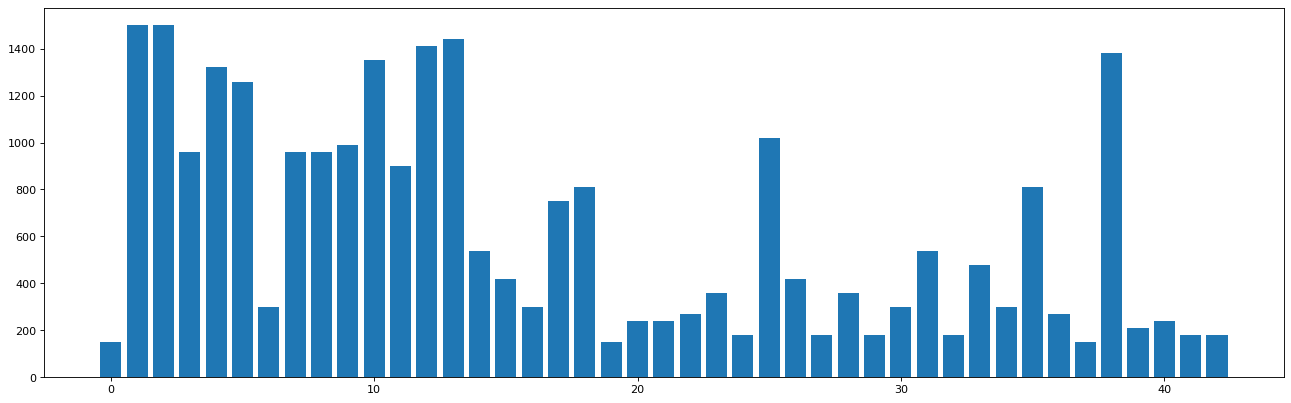

In [11]:
figure(figsize=(20, 6), dpi=80)

plt.bar(x, y)

We can see that there is not really an equality in the dataset, so we may see that for example, for classid 0, we have 150 data which is the less one, therefor the Neural Network will not perform as well as other classes like, for example 1.

Another thing to take into account is to explore the dataset, we can do that visualizing the images. We can use the next cell to see different images, examples:

- Blur images
- Pixel images
- shacked images
- sepia images
- dot images

and maybe much more... but this is what I have found by my self right now.

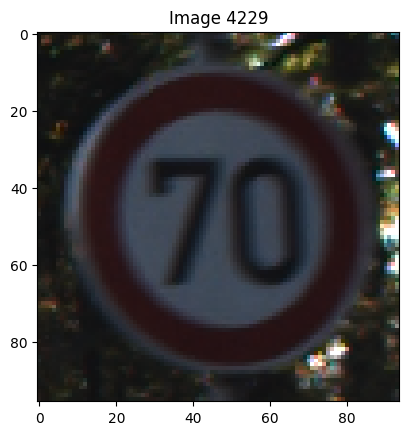

In [12]:
ran_img = random.randrange(0, len(traffic_dt.GTSRB_labels))
plt.title(f"Image {ran_img}")
plt.imshow(traffic_dt.GTSRB_images[ran_img])

# Preprocessing

We need to make sure that the images are all of the same size. You can take the approach you want, I am going to use the mean of width and height.

So now, the width and height from the metadata are going to be old values representing the original sizes of the image.

Another important thing to do is to separate our dataset into two subsets. One for training the neural network and another to test/validate how well the model has done. Sometimes, you will see (as now) that the train dataset is separeted into train and validation. Having validation subset, we can see how well the NN is doing, if the loss of this subset is going higher or at any point goes up instead of down, then we can say that the NN is "memorizing" the training set. This is "memorizing" thing is called **overfitting**.
In this scenario we treat the "test" set as if it were new data taken from the field and the NN we created has to recognize the signs.
Normally we don't wnat our bad performance model to predict on "real data" if we don't have a decent accuracy on validation subset!

Since we don't have a huge dataset, we are going to take a 90/10. this means 90% of the dataset to training and 10% to validate. We could also use 80/20 which is much more used.

A nice way to do this is, as we saw earlier, equilibrating somehow the numbers of each classId so that the model can nearly recognize every image. But... too much work for today, so we are going to shuffle and take whatever we get.

Another thing we are going to do is to convert 0 to 255 to 0 and 1. We can test what is more efficient!! Or you can do it xd

In [13]:
import cv2
import tensorflow as tf

In [14]:
class Preprocess:
    def __init__(self, dataset, norm_image: bool):
        # input variables
        self.norm_image = norm_image
        self.dataset = dataset

        # inside variables
        self.indices = []
        self.processed_images = []
        self.default_resize = self._default_resize()


    def _default_resize(self):
        width_mean = int(sum([int(data[1]) for data in self.dataset.GTSRB_metadata])/len(self.dataset.GTSRB_images))
        height_mean = int(sum([int(data[2]) for data in self.dataset.GTSRB_metadata])/len(self.dataset.GTSRB_images))

        input_shape = (width_mean, height_mean)
        print(f"width_mean: {width_mean} - height_mean: {height_mean}")  
        return input_shape

    def _shuffle(self):
        self.indices = [i for i in range(len(self.dataset.GTSRB_images))]
        np.random.shuffle(self.indices)

    def _split(self, size) -> Dataset:
        percent = int(len(self.dataset.GTSRB_images)*0.9)
        val_percent = int((len(self.dataset.GTSRB_images) - percent) * 0.8)

        # train and test dataset split
        if self.norm_image:
            print("Normalaizing pixel values")
            test_dataset = np.array([tf.cast(cv2.resize(self.dataset.GTSRB_images[i]/255., dsize=size, interpolation=cv2.INTER_LINEAR), tf.float32) for i in self.indices[percent:]])
            train_dataset = np.array([tf.cast(cv2.resize(self.dataset.GTSRB_images[i]/255., dsize=size, interpolation=cv2.INTER_LINEAR), tf.float32) for i in self.indices[val_percent:percent]])
            validate_dataset = np.array([tf.cast(cv2.resize(self.dataset.GTSRB_images[i]/255., dsize=size, interpolation=cv2.INTER_LINEAR), tf.float32) for i in self.indices[:val_percent]])
        else:
            test_dataset = np.array([cv2.resize(self.dataset.GTSRB_images[i], dsize=size, interpolation=cv2.INTER_LINEAR) for i in self.indices[percent:]])
            train_dataset = np.array([cv2.resize(self.dataset.GTSRB_images[i], dsize=size, interpolation=cv2.INTER_LINEAR) for i in self.indices[val_percent:percent]])
            validate_dataset = np.array([cv2.resize(self.dataset.GTSRB_images[i], dsize=size, interpolation=cv2.INTER_LINEAR) for i in self.indices[:val_percent]])

        test_labels_dataset = np.array([self.dataset.GTSRB_labels[i] for i in self.indices[percent:]], dtype=np.uint8)
        train_labels_dataset = np.array([self.dataset.GTSRB_labels[i] for i in self.indices[val_percent:percent]], dtype=np.uint8)
        validate_labels_dataset = np.array([self.dataset.GTSRB_labels[i] for i in self.indices[:val_percent]], dtype=np.uint8)

        # Check the data type of the train_dataset and train_labels_dataset arrays
        print(f"train_dataset type: {train_dataset.dtype}")
        print(f"train_labels_dataset type: {train_labels_dataset.dtype}")

        # Check the shape of the train_dataset and train_labels_dataset arrays
        print(f"train_dataset shape: {train_dataset.shape}")
        print(f"train_labels_dataset shape: {train_labels_dataset.shape}")

        # test
        print(f"test_dataset shape: {test_dataset.shape}")
        print(f"test_labels_dataset shape: {test_labels_dataset.shape}")

        # validate
        print(f"validate_dataset shape: {validate_dataset.shape}")
        print(f"validate_labels_dataset shape: {validate_labels_dataset.shape}")

        # Check if the train_labels_dataset contains any NaN or Inf values
        print(f"Any nan in train_labels_dataset: {np.isnan(train_labels_dataset).any()}")
        print(f"Any inf in train_labels_dataset: {np.isinf(train_labels_dataset).any()}")

        assert(train_dataset.shape[0] == train_labels_dataset.shape[0])
        assert(train_dataset.shape[0] + test_dataset.shape[0] + validate_dataset.shape[0] == len(self.dataset.GTSRB_images))

        processed_dataset = Dataset()
        processed_dataset.test_dataset = test_dataset
        processed_dataset.train_dataset = train_dataset
        processed_dataset.validate_dataset = validate_dataset
        processed_dataset.test_labels_dataset = test_labels_dataset
        processed_dataset.train_labels_dataset = train_labels_dataset
        processed_dataset.validate_labels_dataset = validate_labels_dataset
        return processed_dataset

    def start_preprocess(self, size: int) -> Dataset:
        if size == None:
            size = self.default_resize

        self._shuffle()

        return self._split(size)

In [15]:
preppop = Preprocess(traffic_dt, norm_image = True)

width_mean: 50 - height_mean: 50


In [16]:
preprocessed_dataset = preppop.start_preprocess((32, 32))

Normalaizing pixel values
train_dataset type: float32
train_labels_dataset type: uint8
train_dataset shape: (21845, 32, 32, 3)
train_labels_dataset shape: (21845,)
test_dataset shape: (2664, 32, 32, 3)
test_labels_dataset shape: (2664,)
validate_dataset shape: (2131, 32, 32, 3)
validate_labels_dataset shape: (2131,)
Any nan in train_labels_dataset: False
Any inf in train_labels_dataset: False


In [17]:
# Check the data type of the train_dataset and train_labels_dataset arrays
print(preprocessed_dataset.train_dataset.dtype)
print(preprocessed_dataset.train_labels_dataset.dtype)

# Check the shape of the train_dataset and train_labels_dataset arrays
print(preprocessed_dataset.train_dataset.shape)
print(preprocessed_dataset.train_labels_dataset.shape)

# Check if the train_labels_dataset contains any NaN or Inf values
print(np.isnan(preprocessed_dataset.train_labels_dataset).any())
print(np.isinf(preprocessed_dataset.train_labels_dataset).any())

float32
uint8
(21845, 32, 32, 3)
(21845,)
False
False


# Convolutional Neural Networks

We are going to use Neural Networks, for this we are going to use and compare these ones:

1. Custom NN
2. LeNet-5
3. VGG 16 layers

In [18]:
from enum import Enum
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Activation

In [19]:
class CNN_enum(Enum):
    CUSTOM = 1
    LENET = 2
    VGG16 = 3

In [20]:
class NeuralNetwork:
    def __init__(self):
        self.model = None
        self.input_shape = None

    def summary(self):
        self.model.summary()

    def compile(self):
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    def train(self, x, y, validation_data, epochs=10):
        return self.model.fit(x, y, epochs=epochs, validation_data=validation_data)

    def evaluate(self, x_test, y_test):
        self.model.evaluate(x_test, y_test)

## Custom CNN

In [21]:
class CustomCNN(NeuralNetwork):
    def __init__(self, shape):
        self.model = tf.keras.models.Sequential([
            Conv2D(6, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                    input_shape=shape[1:]),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Flatten(),
            Dense(120, activation='relu'),
            Dense(84, activation='relu'),
            Dense(43),
        ])
        self.input_shape = shape

## Lenet

In [22]:
class Lenet(NeuralNetwork):
    def __init__(self, shape):
        self.model = tf.keras.models.Sequential([
            Conv2D(6, 5, activation='tanh', input_shape=shape[1:]),
            AveragePooling2D(2),

            Conv2D(16, 5, activation='tanh'),
            AveragePooling2D(2),

            Dense(120, activation='tanh'),
            Dense(84, activation='softmax'),
            Dense(10, activation='softmax')
        ])

        self.input_shape = shape

## VGG 16 layers

In [23]:
class VGG16(NeuralNetwork):
    def __init__(self, shape):
        self.model = tf.keras.models.Sequential([
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=shape[1:]),
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            Conv2D(filters=8, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(1000, activation='relu'),

            Dense(43, activation='softmax'),
        ])

        self.input_shape = shape

# Try different things!

In [24]:
def test_with_shape(type: CNN_enum, dataset: Dataset, shape: tuple, epochs=10, norm_img = True):
    preppop = Preprocess(dataset, norm_image=norm_img)
    preprocessed_dt = preppop.start_preprocess(shape)
    nn = None
    
    if CNN_enum.CUSTOM:
        nn = CustomCNN(preprocessed_dt.train_dataset.shape)
    elif CNN_enum.LENET:
        nn = Lenet(preprocessed_dt.train_dataset.shape)
    elif CNN_enum.VGG16:
        nn = VGG16(preprocessed_dt.train_dataset.shape)
    
    print(nn.summary())
    nn.compile()

    history = nn.train(preprocessed_dt.train_dataset, preprocessed_dt.train_labels_dataset,
                    (preprocessed_dt.validate_dataset, preprocessed_dt.validate_labels_dataset),
                    epochs=epochs)

    print("\nEvaluation with test labels ->")
    nn.evaluate(preprocessed_dt.test_dataset, preprocessed_dt.test_labels_dataset)

    return nn, history, preprocessed_dt

In [25]:
def plot_graph(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,15))

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].legend(['Train', 'Val'])

    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].legend(['Train', 'Val'])

In [26]:
def predict_with_random_image(cnn: NeuralNetwork, dataset: Dataset):
    # index = np.random.choice(np.array(GTSRB_images).shape[0], 1, replace=False)[0]
    index = random.randrange(0, dataset.test_dataset.shape[1])

    img = dataset.test_dataset[index]
    classId = dataset.test_labels_dataset[index]

    # reshape_img = np.resize(img, cnn.input_shape)
    prediction = cnn.model.predict(np.array([img]))

    plt.title(f"Image {ran_img}")
    plt.imshow(img)

    print(f"Length of predictions: {len(prediction[0])} (should be same size as # of classIds)")
    print(f"Highest score: {np.amax(prediction[0])}")
    print(f"Real ClassId: {classId}")
    print(f"Predicted ClassId: {np.argmax(prediction[0])}")
    print(f"Good prediction? {np.argmax(prediction[0]) == classId}")

    return prediction

### Custom
- (32, 32, 3)
- (mean, mean, 3)


##### 32 size

In [ ]:
customNN32, custom32_history, processed_dt = test_with_shape(CNN_enum.CUSTOM, traffic_dt, (32, 32))

width_mean: 50 - height_mean: 50
Normalaizing pixel values
train_dataset type: float32
train_labels_dataset type: uint8
train_dataset shape: (21845, 32, 32, 3)
train_labels_dataset shape: (21845,)
test_dataset shape: (2664, 32, 32, 3)
test_labels_dataset shape: (2664,)
validate_dataset shape: (2131, 32, 32, 3)
validate_labels_dataset shape: (2131,)
Any nan in train_labels_dataset: False
Any inf in train_labels_dataset: False
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                       

In [ ]:
plot_graph(custom32_history)

In [ ]:
prediction = predict_with_random_image(customNN32, processed_dt)

##### Mean size

In [ ]:
customNN_mean, customMean_history, processed_dt = test_with_shape(CNN_enum.CUSTOM, traffic_dt, None, epochs=3)

In [ ]:
plot_graph(customMean_history)

In [ ]:
predict = predict_with_random_image(customNN_mean, processed_dt)

### Lenet
- (32, 32, 3)
- (mean, mean, 3)


##### 32 size

In [ ]:
lenetNN_32, lenet32_history, processed_dt = test_with_shape(CNN_enum.LENET, traffic_dt, (32, 32, 3))

In [ ]:
plot_graph(lenet32_history)

In [ ]:
predict_with_random_image(lenetNN_32, processed_dt)

##### Mean size

In [ ]:
lenetNN_Mean, lenetMean_history = test_with_shape(CNN_enum.LENET, traffic_dt, None)

In [ ]:
plot_graph(lenetMean_history)

In [ ]:
predict_with_random_image(lenetNN_Mean, processed_dt)

### VGG16
- (32, 32, 3)
- (mean, mean, 3)


##### 32 size

In [ ]:
vggNN_32, vgg32_history, processed_dt = test_with_shape(CNN_enum.VGG16, traffic_dt, (32, 32), epochs=30)

In [ ]:
plot_graph(vgg32_history)

In [ ]:
predictions = predict_with_random_image(vggNN_32, processed_dt)

##### Mean size

In [ ]:
vggNN_mean, vggMean_history, processed_dt = test_with_shape(CNN_enum.VGG16, traffic_dt, None, epochs=30)

In [ ]:
plot_graph(vggMean_history)

In [ ]:
prediction = predict_with_random_image(vggNN_mean, processed_dt)

# Extra
This is an extra part where we will try to predict, not only the classId but also the position of the sign. To do this, we have everything we need, except for some little things.

We have right now 43 output values, but for this scenario we need 2 more which will represent the TOP_LEFT and BOTTOM_RIGHT corners. These values will be the first 2.

This is how the prediction will be: [TOP_LEFT, BOTTOM_RIGHT, 1, 2, 3, ..., 41, 42, 43]